In [2]:
library(ANCOMBC)
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")
library(microViz)
library("ggpubr")
library("speedyseq")

Loading required package: phyloseq


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2022 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.4
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.4     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ microbiome::alpha() masks ggplot2::alpha()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
microViz version 0.12.7 - Copyright (C) 2021-2025 David Barnett
! Website: https://david-barnett.github.io/microViz
✔ Useful?  For cita

In [3]:
# Read in the 16S qza files and clean them up for phyloseq
ASVs <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/table-BacArc_resistada.qza")
ASVs <- ASVs$data # Extract the count data from list

# Convert taxonomy info to data frame with correct taxonomy labels
taxa_16S <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/taxonomy_resistada.qza")
taxa_16S <- taxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>% 
select(-Confidence) %>% arrange(Feature.ID) %>% mutate(ASV = 1:n()) %>% 
mutate(newcol = "ASV") %>%
unite("ASVs", newcol:ASV) %>%
filter(Phylum !=" p__Chlorophyta") %>%
filter(Phylum !="NA")
#asv_tab$asv_id <- rownames(asv_tab) # add a new column for ids
tree_file <-read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/rooted-BacArc_resistada.qza")$data

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 5374 rows [3, 6, 9, 11,
12, 14, 15, 16, 17, 18, 22, 23, 27, 31, 36, 38, 42, 45, 49, 51, ...].”


In [4]:
meta = read.csv("/Users/stephanie.rosales/Documents/omics_projects/Resitada/metadata_RESISTADA.csv", 
                header = T, row.names = 1,
na.strings = c("", "NA")) %>% 
mutate(
  Genotype = Genotype %>%
    str_replace_all("Kelsey-1", "Kelsey1") %>%
    str_replace_all("Cooper-9", "Cooper9")
)


#arrange metadata 
meta$Genotype<-factor(meta$Genotype, 
                              levels=c("FM19", "FM6", "FM9", "U44",
                                       "FM14", "Elkhorn","K2",
                                      "Acerv2", "Kelsey1", "Cooper9"))

 meta$Combo<-factor(meta$Combo,
                       levels = c("Ambient_Placebo", "Ambient_Pathogen", "NH4_Placebo", "NH4_Pathogen"))


In [5]:
#create phyloseq object
ps= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(as.data.frame(taxa_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(meta), tree_file)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 9492 taxa and 280 samples ]:
sample_data() Sample Data:        [ 280 samples by 62 sample variables ]:
tax_table()   Taxonomy Table:     [ 9492 taxa by 8 taxonomic ranks ]:
phy_tree()    Phylogenetic Tree:  [ 9492 tips and 8365 internal nodes ]:
taxa are rows

In [6]:
#remove duplicate samples
dups = c("N169_256_R2", "N157_265_R2", "N165_296_R2", "N161_A067_R2", "N185_A088_R2",
                                 "N164_A089_R2","N119_A107","N267_A110","N7_A114", "N156_A115","N158_A116",
                                 "N101_A118","N160_A119","N277_A125")

ps = subset_samples(ps, !ID %in% dups & Genotype!=c("U41"))
                                                    #,"U44")) 
ps


ps=subset_taxa(ps, Phylum!="NA")
ps


phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 9492 taxa and 252 samples ]:
sample_data() Sample Data:        [ 252 samples by 62 sample variables ]:
tax_table()   Taxonomy Table:     [ 9492 taxa by 8 taxonomic ranks ]:
phy_tree()    Phylogenetic Tree:  [ 9492 tips and 8365 internal nodes ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 9492 taxa and 252 samples ]:
sample_data() Sample Data:        [ 252 samples by 62 sample variables ]:
tax_table()   Taxonomy Table:     [ 9492 taxa by 8 taxonomic ranks ]:
phy_tree()    Phylogenetic Tree:  [ 9492 tips and 8365 internal nodes ]:
taxa are rows

In [7]:
#subset data
ps_Clipped =subset_samples(ps, Type=="Clipped")
ps_Clipped

ps_paired = subset_samples(ps_Clipped, Pairs=="paired")
ps_paired

ps_both = subset_samples(ps_Clipped, filter_unpair=="no")
ps_both

select =c("Ambient_Placebo", "Ambient_Pathogen")
#only placebo
ps_disease =subset_samples(ps_paired , Combo %in% select)
ps_disease

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 9492 taxa and 192 samples ]:
sample_data() Sample Data:        [ 192 samples by 62 sample variables ]:
tax_table()   Taxonomy Table:     [ 9492 taxa by 8 taxonomic ranks ]:
phy_tree()    Phylogenetic Tree:  [ 9492 tips and 8365 internal nodes ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 9492 taxa and 151 samples ]:
sample_data() Sample Data:        [ 151 samples by 62 sample variables ]:
tax_table()   Taxonomy Table:     [ 9492 taxa by 8 taxonomic ranks ]:
phy_tree()    Phylogenetic Tree:  [ 9492 tips and 8365 internal nodes ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 9492 taxa and 174 samples ]:
sample_data() Sample Data:        [ 174 samples by 62 sample variables ]:
tax_table()   Taxonomy Table:     [ 9492 taxa by 8 taxonomic ranks ]:
phy_tree()    Phylogenetic Tree:  [ 9492 tips and 8365 internal nodes ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 9492 taxa and 57 samples ]:
sample_data() Sample Data:        [ 57 samples by 62 sample variables ]:
tax_table()   Taxonomy Table:     [ 9492 taxa by 8 taxonomic ranks ]:
phy_tree()    Phylogenetic Tree:  [ 9492 tips and 8365 internal nodes ]:
taxa are rows

In [8]:
ps_disease_fill = filter_taxa(ps_disease, function(x) sum(x) > 30, TRUE) %>% tax_fix()
ps_disease_fill
                           
                                                                                    

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1527 taxa and 57 samples ]:
sample_data() Sample Data:        [ 57 samples by 62 sample variables ]:
tax_table()   Taxonomy Table:     [ 1527 taxa by 8 taxonomic ranks ]:
phy_tree()    Phylogenetic Tree:  [ 1527 tips and 1375 internal nodes ]:
taxa are rows

In [9]:
sample_data(ps_disease_fill) %>%
  group_by(Combo, Health) %>%
  summarize(count = n())

`summarise()` has grouped output by 'Combo'. You can override using the
`.groups` argument.


Combo,Health,count
<fct>,<chr>,<int>
Ambient_Placebo,AH,28
Ambient_Pathogen,AH,8
Ambient_Pathogen,DL,21


In [10]:
set.seed(123)
output = ancombc2(data = ps_disease_fill , tax_level = "ASVs",
                  fix_formula = "Combo", 
                  p_adj_method = "holm",  pairwise = TRUE,
                  group = "Combo",struc_zero = TRUE, alpha = 0.001,
                  dunnet = TRUE,
                  n_cl=4, prv_cut = 0.01, lib_cut = 1000
                 )
        

Checking the input data type ...

The input data is of type: phyloseq

PASS

Checking the sample metadata ...

The specified variables in the formula: Combo

The available variables in the sample metadata: sample_names, featurecounts, Initial_sample_ID, Tag, start_date, event_date, collection_date, Date, TimePoint, Replicate, Genotype, label, Nursery, Lat, Long, lat_long, organism, geo_loc_name, env_local_scale, env_broad_scale, env_medium, waterBody, countryCode, amplicon_sequenced, Nutrients, Diseased, Combo, Tank_N, Tank_D1, Tank_D2, Type, Health, Outcome, Notes, Severity, Survivorship, Pairs, filter_unpair, Combo_health, Archive_box, Genotype.1, NH4_Susceptibility, Disease_Susceptibility, NH4_Disease_Susceptibility, Expected, Surv_disease, Surv_nutrients, surv, std.err, barcode_label, barcode_seq, ID, Sequencing_Round, Plate_Name, Plate_Barcode, Well_Position, Sequence_Name, Illumina5_Adapter, Forward_Primer_Pad, Golay_Barcode, X515FB_Forward_Primer, Primer_For_PCR

PASS

Checking 

In [11]:
res=output$res
head(res)
dim(res)

taxa_df = tax_table(ps_disease_fill) %>% as.data.frame() %>% rownames_to_column("taxon")
head(taxa_df)

df_fig = res %>% left_join(taxa_df, by = "taxon")
dim(df_fig)
head(df_fig)

,taxon,lfc_(Intercept),lfc_ComboAmbient_Pathogen,se_(Intercept),se_ComboAmbient_Pathogen,W_(Intercept),W_ComboAmbient_Pathogen,p_(Intercept),p_ComboAmbient_Pathogen,q_(Intercept),q_ComboAmbient_Pathogen,diff_(Intercept),diff_ComboAmbient_Pathogen,passed_ss_(Intercept),passed_ss_ComboAmbient_Pathogen
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
1,3e25ffb24420d1120183e84047dd818e,0.80631376,-1.5498996,0.04945520,0.1731880,16.303924,-8.949233,0.003740877,0.01225705,0.9501828,1,FALSE,FALSE,TRUE,TRUE
2,cbfd4b77b41358f00d733a53c6e5f65c,-0.47183056,1.0070371,NaN,0.1545454,NaN,6.516124,1.000000000,1.00000000,1.0000000,1,FALSE,FALSE,TRUE,TRUE
3,536dedef3e7a8a5e5f98fb8134869ac6,-1.08381023,2.9356298,NaN,0.1545454,NaN,18.995258,1.000000000,1.00000000,1.0000000,1,FALSE,FALSE,TRUE,TRUE
4,4024e22b8908b65e2669f0308f75d153,-0.08009792,0.2638787,NaN,0.1545454,NaN,1.707451,1.000000000,1.00000000,1.0000000,1,FALSE,FALSE,TRUE,TRUE
5,f3dd427acd4dd5422d28130de4a38d07,0.27634512,-0.5217355,0.05659875,0.1599972,4.882531,-3.260904,0.039480379,0.08256298,1.0000000,1,FALSE,FALSE,TRUE,TRUE
6,d1525c3fa5ef9858663670393a6771a1,-0.55859158,0.6124394,NaN,0.1545454,NaN,3.962845,1.000000000,1.00000000,1.0000000,1,FALSE,FALSE,TRUE,TRUE


[1] 300  15

,taxon,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,c93a0d44c91ddf57f16e348b33b0c6f7,d__Bacteria,p__Proteobacteria,p__Proteobacteria Phylum,p__Proteobacteria Phylum,p__Proteobacteria Phylum,p__Proteobacteria Phylum,p__Proteobacteria Phylum,ASV_7982
2,3e7ce5f07ff5b6d786a9b8e46b3bdb73,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,ASV_2513
3,e7053ff6c11d7fb2ada9ebee52ea34a9,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,ASV_9187
4,837e41807d744880bc553ebc48194b59,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,ASV_5231
5,79ab9443abaffaeed5e40d80215d7822,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,c__Alphaproteobacteria Class,ASV_4878
6,bbb9293c1a19382c3373b6a9b8e716b8,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Rickettsiaceae,g__Candidatus_Megaira,s__uncultured_Rickettsiales,ASV_7425


[1] 300  23

,taxon,lfc_(Intercept),lfc_ComboAmbient_Pathogen,se_(Intercept),se_ComboAmbient_Pathogen,W_(Intercept),W_ComboAmbient_Pathogen,p_(Intercept),p_ComboAmbient_Pathogen,q_(Intercept),⋯,passed_ss_(Intercept),passed_ss_ComboAmbient_Pathogen,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,3e25ffb24420d1120183e84047dd818e,0.80631376,-1.5498996,0.04945520,0.1731880,16.303924,-8.949233,0.003740877,0.01225705,0.9501828,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Kordiimonadales,f__uncultured,g__uncultured,s__uncultured_Kordiimonas,ASV_2500
2,cbfd4b77b41358f00d733a53c6e5f65c,-0.47183056,1.0070371,NaN,0.1545454,NaN,6.516124,1.000000000,1.00000000,1.0000000,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Caulobacterales,f__Hyphomonadaceae,g__uncultured,g__uncultured Genus,ASV_8098
3,536dedef3e7a8a5e5f98fb8134869ac6,-1.08381023,2.9356298,NaN,0.1545454,NaN,18.995258,1.000000000,1.00000000,1.0000000,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Caulobacterales,f__Hyphomonadaceae,g__uncultured,g__uncultured Genus,ASV_3367
4,4024e22b8908b65e2669f0308f75d153,-0.08009792,0.2638787,NaN,0.1545454,NaN,1.707451,1.000000000,1.00000000,1.0000000,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Caulobacterales,f__Hyphomonadaceae,g__uncultured,g__uncultured Genus,ASV_2577
5,f3dd427acd4dd5422d28130de4a38d07,0.27634512,-0.5217355,0.05659875,0.1599972,4.882531,-3.260904,0.039480379,0.08256298,1.0000000,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Caulobacterales,f__Hyphomonadaceae,g__uncultured,g__uncultured Genus,ASV_9663
6,d1525c3fa5ef9858663670393a6771a1,-0.55859158,0.6124394,NaN,0.1545454,NaN,3.962845,1.000000000,1.00000000,1.0000000,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Caulobacterales,f__Hyphomonadaceae,g__Algimonas,s__uncultured_bacterium,ASV_8305


In [12]:
df_fig = res %>% left_join(taxa_df, by = "taxon") %>%
#filter(lfc_ComboAmbient_Pathogen < -1.5 | lfc_ComboAmbient_Pathogen > 1.5)  %>%
filter(passed_ss_ComboAmbient_Pathogen == "TRUE")  %>%
filter(p_ComboAmbient_Pathogen<=0.01)
dim(df_fig)
head(df_fig)
write_csv(df_fig, "/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/Ancom_disease.csv")

[1] 30 23

,taxon,lfc_(Intercept),lfc_ComboAmbient_Pathogen,se_(Intercept),se_ComboAmbient_Pathogen,W_(Intercept),W_ComboAmbient_Pathogen,p_(Intercept),p_ComboAmbient_Pathogen,q_(Intercept),⋯,passed_ss_(Intercept),passed_ss_ComboAmbient_Pathogen,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,544e3f697c0460869c81cc5c7e774c6a,0.8780675,-0.9626817,NaN,0.1544443,NaN,-6.233197,1.000000e+00,0.0083270834,1.000000000,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_3397
2,ea14aa41fbcf1e8af5908e975da064b8,-0.3138999,0.5486823,0.05890317,0.1587283,-5.329083,3.456740,4.752585e-04,0.0071977400,0.126894013,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,g__Shimia,g__Shimia Genus,ASV_9309
3,ac6820155a85d9cc15f8f62406e10e42,-0.6081084,0.6754358,NaN,0.1573541,NaN,4.292456,1.000000e+00,0.0007443298,1.000000000,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,g__Shimia,g__Shimia Genus,ASV_6816
4,c2e0cafeeb1e69533d2bebd4f3ff5a87,-0.4658607,0.7242512,0.06320069,0.1612479,-7.371134,4.491539,2.394061e-05,0.0011581559,0.006727311,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_7717
5,46f3b8bd39ad98e3a511ccd4d594ffc9,-1.5173327,1.9485574,NaN,0.1558042,NaN,12.506452,1.000000e+00,0.0011019500,1.000000000,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodospirillales,f__Terasakiellaceae,g__uncultured,g__uncultured Genus,ASV_2863
6,a3c29bcb6997cfe572a474e58291af1d,-0.1803456,1.0549898,0.08898853,0.1621810,-2.026616,6.505015,1.126457e-01,0.0028817475,1.000000000,⋯,TRUE,TRUE,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Spirochaetales,f__Spirochaetaceae,g__Spirochaeta_2,g__Spirochaeta_2 Genus,ASV_6512


Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(d[d > tolerance]):
“no non-missing arguments to min; returning Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(d[d > tolerance]):
“no non-missing arguments to min; returning Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(d[d > tolerance]):
“no non-missing arguments to min; returning Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(d[d > tolerance]):
“no non-missing arguments to min; returning Inf”
Warning message in min(x

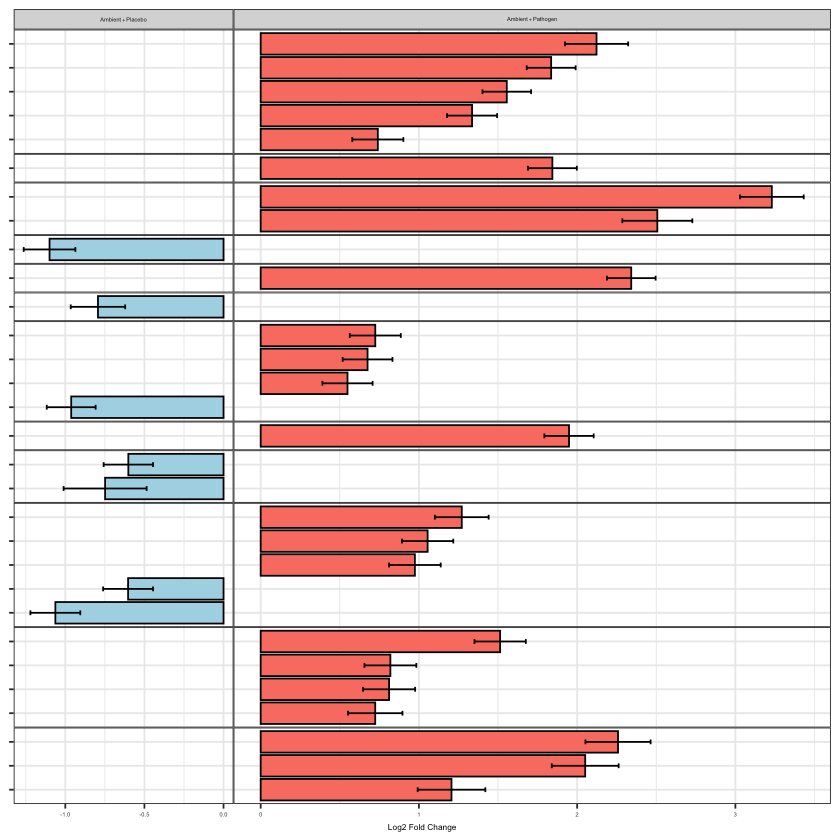

In [13]:
combo_labs <- as_labeller(c("Ambient Pathogen" = "Ambient+Pathogen",
                          "Ambient Placebo" = "Ambient+Placebo"), default = label_parsed)

F1 <- df_fig %>%
#filter(lfc_ComboAmbient_Pathogen < -1 | lfc_ComboAmbient_Pathogen > 1)  %>%
#filter(ASVs!=ASV961
 filter(passed_ss_ComboAmbient_Pathogen == "TRUE") %>%
  mutate_if(is.character, str_replace_all, pattern = "o__", replacement = "") %>%
 
  mutate(
    direction = ifelse(lfc_ComboAmbient_Pathogen > 0, "Ambient Pathogen", "Ambient Placebo"),
    direction = factor(direction, levels = c("Ambient Placebo", "Ambient Pathogen"))
  ) %>%
  ggplot(aes(x = reorder(ASVs, lfc_ComboAmbient_Pathogen), y = lfc_ComboAmbient_Pathogen, fill = direction)) +
  geom_bar(stat = "identity", color = "black") +
  geom_errorbar(aes(ymin = lfc_ComboAmbient_Pathogen - se_ComboAmbient_Pathogen, 
                    ymax = lfc_ComboAmbient_Pathogen + se_ComboAmbient_Pathogen), width = 0.2) +
  coord_flip() +
  labs(
    x = "ASVs",
    y = "Log2 Fold Change",
    fill = "Direction"
  ) +
  scale_fill_manual(values = c("Ambient Pathogen" = "salmon", "Ambient Placebo" = "lightblue")) +
  facet_grid(Order ~
             direction, 
             space = "free", scales = "free",
             switch = "y",
             labeller = labeller(direction = combo_labs)
            ) +
  theme_bw() +
  theme(
    axis.title.x = element_text(size = 5),
    axis.title.y = element_blank(),
    axis.text.x = element_text(size = 3.5),
    axis.text.y = element_blank(),
    strip.text.x = element_text(size = 3.4),
    strip.text.y = element_blank(),
    #  strip.text.y = element_text(size=5),
    legend.text = element_text(size = 5),
    legend.title = element_text(size = 5),
    legend.position = "none",
    panel.spacing.x = unit(0.0, "lines"),
    panel.spacing.y = unit(0.0, "lines")
  )
F1

In [14]:
psr_fill_melt = ps_disease  %>%  
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()   


taxa_fil= df_fig %>% column_to_rownames("taxon")%>%
as.matrix


ps_DLPL=phyloseq(otu_table(ASVs, taxa_are_rows=TRUE), 
               sample_data(meta),
              tax_table(taxa_fil))
ps_DLPL=subset_samples(ps_DLPL, !ID %in% dups & Genotype!="U41")
ps_DLPL



ps_ancom_APa = subset_samples(ps_DLPL,
                              Pairs=="paired" & Combo %in% select 
                             )

ps_ancom_APa 

psr_fill_melt = ps_ancom_APa  %>%  
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()  
head(psr_fill_melt)

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 30 taxa and 252 samples ]:
sample_data() Sample Data:        [ 252 samples by 62 sample variables ]:
tax_table()   Taxonomy Table:     [ 30 taxa by 22 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 30 taxa and 57 samples ]:
sample_data() Sample Data:        [ 57 samples by 62 sample variables ]:
tax_table()   Taxonomy Table:     [ 30 taxa by 22 taxonomic ranks ]:
taxa are rows

,OTU,Sample,Abundance,sample_names,featurecounts,Initial_sample_ID,Tag,start_date,event_date,collection_date,⋯,passed_ss_(Intercept),passed_ss_ComboAmbient_Pathogen,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,128b9e56c2fa2a8cd24c5e260d0f8335,N131-200,NaN,N131-200,650,131,200,8/19/20,11/6/20,11/6/20,⋯,TRUE,TRUE,d__Bacteria,p__Myxococcota,c__Myxococcia,o__Myxococcales,f__Myxococcaceae,g__P3OB-42,s__uncultured_bacterium,ASV_751
2,1f388d6a52fb1fe4e6010cd40d4cbda6,N131-200,NaN,N131-200,650,131,200,8/19/20,11/6/20,11/6/20,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,g__MD3-55 Genus,ASV_1233
3,1fc63b2c06f3eaeb772739171240b880,N131-200,NaN,N131-200,650,131,200,8/19/20,11/6/20,11/6/20,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,g__MD3-55 Genus,ASV_1262
4,2199ba36a465deebc04fc9cff6ae0559,N131-200,NaN,N131-200,650,131,200,8/19/20,11/6/20,11/6/20,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Oceanospirillales,f__Endozoicomonadaceae,g__Endozoicomonas,s__Acropora_cervicornis,ASV_1335
5,26a2c67d3871c75aaa4f85d4e1ee6f07,N131-200,NaN,N131-200,650,131,200,8/19/20,11/6/20,11/6/20,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Pseudoalteromonadaceae,g__Pseudoalteromonas,g__Pseudoalteromonas Genus,ASV_1542
6,2858b9fde3b089e24129923e26bfb2e7,N131-200,NaN,N131-200,650,131,200,8/19/20,11/6/20,11/6/20,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Colwelliaceae,g__Thalassotalea,s__Thalassotalea_ganghwensis,ASV_1612



Ambient+Disease Ambient+Placebo 
             93             211 


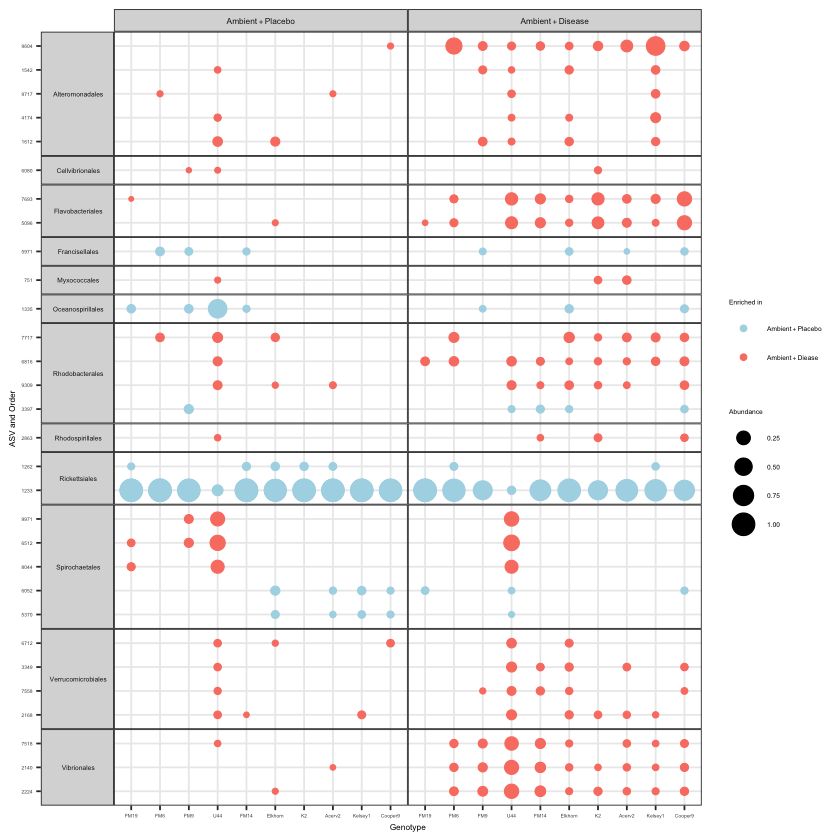

In [15]:
library(stringr)
psr_fill_melt <- psr_fill_melt %>%
  mutate(Combo = factor(Combo, levels = c("Ambient_Placebo", "Ambient_Pathogen", "NH4_Placebo", "NH4_Pathogen")))
# Define labellers
combo_labs <- as_labeller(c(
  "Ambient_Placebo" = "Ambient+Placebo",
  "Ambient_Pathogen" = "Ambient+Disease",
  "NH4_Placebo" = "NH[4]+Placebo",
  "NH4_Pathogen" = "NH[4]+Disease"
), default = label_parsed)


lab1 <- c(expression(Ambient+Placebo),
          
          expression(Ambient+Diease))
# Plot
F2 <- psr_fill_melt %>%
  as.data.frame() %>%
  mutate(
    Abundance = as.numeric(as.character(Abundance)),
    lfc_ComboAmbient_Pathogen = as.numeric(str_trim(as.character(lfc_ComboAmbient_Pathogen)))
  ) %>%
  filter(
    passed_ss_ComboAmbient_Pathogen == "TRUE",
    Abundance > 0,
    !is.na(Severity)
  ) %>%
  mutate(
   Enriched  = ifelse(lfc_ComboAmbient_Pathogen > 0, "Ambient+Placebo", "Ambient+Disease")
  ) %>%
  { print(table(.$Enriched)); . } %>%
  mutate(across(where(is.character), ~ str_replace_all(.x, "o__", ""))) %>%
  mutate(across(where(is.character), ~ str_replace_all(.x, "ASV_", ""))) %>%

  ggplot(aes(x = Genotype, y = reorder(ASVs, lfc_ComboAmbient_Pathogen))) +
  geom_point(aes(size = Abundance, color = Enriched)) +
  scale_color_manual("Enriched in", values = c("lightblue", "salmon"),labels=lab1) +
  facet_grid(
    Order ~ Combo,
    space = "free",
    scales = "free",
    switch = "y",
      labeller = labeller(Combo = combo_labs
    )
  ) +
  theme_bw() +
  theme(
    axis.title.x = element_text(size = 5),
    axis.title.y = element_text(size = 5),
    axis.text.x = element_text(size = 3),
    axis.text.y = element_text(size = 3),
    strip.text.y = element_text(size = 4),
    strip.text.y.left = element_text(angle = 0),
    strip.text.x = element_text(size = 5),
    legend.text = element_text(size = 4),
    legend.title = element_text(size = 4),
    panel.spacing.x = unit(0.0, "lines"),
    panel.spacing.y = unit(0.0, "lines")
  ) +
#theme(axis.text.x = element_text(angle = 20, hjust = 1)) +
#guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
  ylab("ASV and Order")
F2

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(d[d > tolerance]):
“no non-missing arguments to min; returning Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(d[d > tolerance]):
“no non-missing arguments to min; returning Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(d[d > tolerance]):
“no non-missing arguments to min; returning Inf”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”
Warning message in min(d[d > tolerance]):
“no non-missing arguments to min; returning Inf”
Warning message in min(x

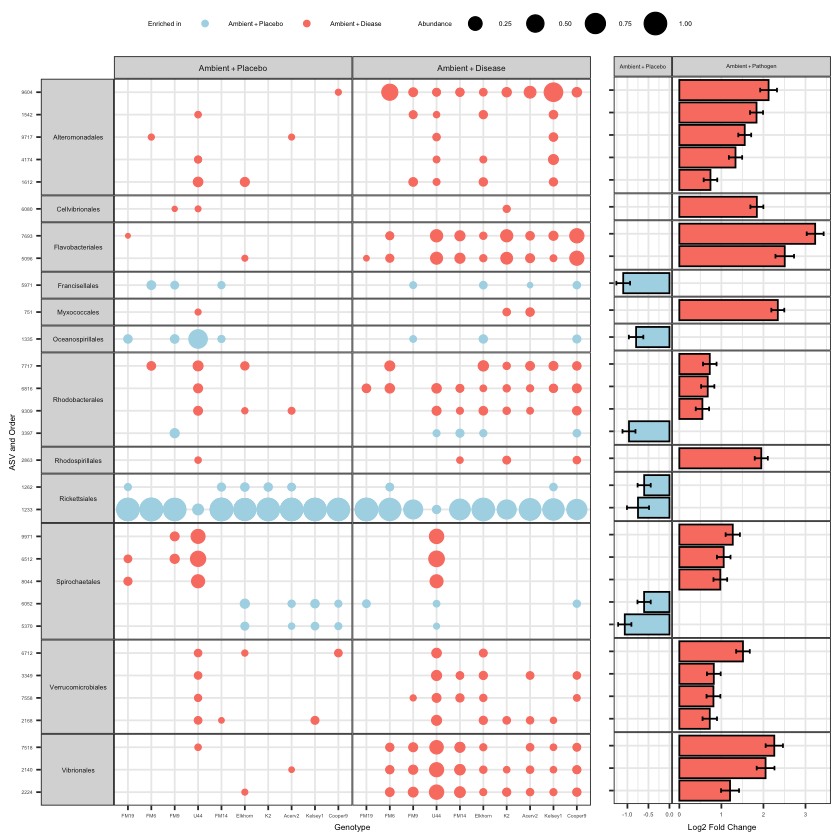

In [16]:
 ggpubr::ggarrange(F2, F1, common.legend = TRUE, legend = "top",
                   widths=c(2,0.8))
ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/SuppFig4.png", 
      width = 6, height = 4, units = "in", dpi=300)